## Proyecto Comparacionde modelos de Series Temporales - pt2

__Objetivo__: Mostrar la evolución de la complejidad del modelado, desde ARIMA, SARIMA, RNN y LSTM, para predecir tiempos de vuelta y presentar los resultados en un informe ejecutivo.

En esta segunda parte avanzamos desde los modelos estadísticos clásicos hacia el Deep Learning para analizar uno de los finales más dramáticos en la historia de la Fórmula 1: la última carrera de la temporada 2021 entre Verstappen y Hamilton.

El objetivo es construir y comparar dos tipos de Redes Neuronales Recurrentes, una RNN simple y una LSTM, para modelar el ritmo de carrera de cada piloto. Utilizando sus datos históricos de la carrera, pronosticaremos cuál habría sido su rendimiento "normal" en las vueltas finales.

Finalmente, compararemos estas predicciones con el resultado real para cuantificar el impacto de los eventos de la última vuelta y demostrar la capacidad de estos modelos para capturar patrones complejos de rendimiento.

### Modelado con SimpleRNN


In [30]:
#Herramientas
#!pip install fastf1 tensorflow scikit-learn matplotlib seaborn

import fastf1 as ff1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, SimpleRNN, Dropout, LayerNormalization

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')
#TensorFlow Warning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [31]:
#Habilitar cache de Fastf1
cache_dir = "cache_folder_fastf1"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
ff1.Cache.enable_cache(cache_dir)

#Carga de datos de la sesion de carrera
print("Cargando datos de la sesión... (puede demorar unos minutos)")
session = ff1.get_session(2021, 'Abu Dhabi', 'R')
session.load()
print('Datos cargados!')

core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Abu Dhabi Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info


Cargando datos de la sesión... (puede demorar unos minutos)


req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           INFO 	Processing timing data...
INFO:fastf1.fastf1.core:Processing timing data...
core        WARNING 	No lap data for driver 9
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 9)
req            INFO 	Using cached data for car_data
INFO:fastf1.fastf1.req:Using cached data for car_data
req            INFO 	Using cached data

Datos cargados!


In [32]:
# Seleccionar todas las vueltas de los pilotos
laps_ver = session.laps.pick_driver('VER')
laps_ham = session.laps.pick_driver('HAM')

# Crear nuestro DataFrame principal para el análisis
lap_times_ver = pd.DataFrame()
lap_times_ver['LapTime'] = laps_ver['LapTime'].dt.total_seconds()

lap_times_ham = pd.DataFrame()
lap_times_ham['LapTime'] = laps_ham['LapTime'].dt.total_seconds()

#Indice (Número de vuelta)
lap_times_ver.index = laps_ver['LapNumber']
lap_times_ham.index = laps_ham['LapNumber']

# Limpiamos los datos: eliminamos la primera vuelta y cualquier vuelta anómala (ej. Safety Car lento)
# que no sea parte de un stint normal.
lap_times_ver = lap_times_ver[lap_times_ver['LapTime'] < 99] # Un filtro simple para eliminar outliers obvios
lap_times_ham = lap_times_ham[lap_times_ham['LapTime']< 99]

print("Datos de Verstappen cargados:", lap_times_ver.shape)
print("Datos de Hamilton cargados:", lap_times_ham.shape)


Datos de Verstappen cargados: (50, 1)
Datos de Hamilton cargados: (51, 1)


In [33]:
print("Primeras 5 vueltas rápidas de Verstappen")
print(lap_times_ver.head())
print("\nPrimeras 5 vueltas rápidas de Hamilton")
print(lap_times_ham.head())

# DataFrame Comparativo
# DataFrames unidos por el índice (Número de Vuelta)
combined_laps_df = pd.concat([lap_times_ver, lap_times_ham], axis=1)

# Renombrar las columnas
combined_laps_df.columns = ['LapTimeVer', 'LapTimeHam']

print("\nDataFrame Comparativo (columna a columna)")
print(combined_laps_df.head(10))

Primeras 5 vueltas rápidas de Verstappen
           LapTime
LapNumber         
1.0         92.800
2.0         89.103
3.0         88.827
4.0         89.026
5.0         88.718

Primeras 5 vueltas rápidas de Hamilton
           LapTime
LapNumber         
1.0         91.686
2.0         88.791
3.0         88.587
4.0         88.789
5.0         88.630

DataFrame Comparativo (columna a columna)
           LapTimeVer  LapTimeHam
LapNumber                        
1.0            92.800      91.686
2.0            89.103      88.791
3.0            88.827      88.587
4.0            89.026      88.789
5.0            88.718      88.630
6.0            88.707      88.593
7.0            88.636      88.550
8.0            88.817      88.585
9.0            88.671      88.356
10.0           88.890      88.216


In [34]:
# Seaborn funciona mejor, en formato formato "ancho" a "largo" (melt) el DataFrame
tidy_df = combined_laps_df.reset_index().melt(
    id_vars='LapNumber',
    var_name='Piloto',
    value_name='Tiempo de Vuelta'
)

print("\nDatos en formato 'Tidy' para graficar")
print(tidy_df.head())


Datos en formato 'Tidy' para graficar
   LapNumber      Piloto  Tiempo de Vuelta
0        1.0  LapTimeVer            92.800
1        2.0  LapTimeVer            89.103
2        3.0  LapTimeVer            88.827
3        4.0  LapTimeVer            89.026
4        5.0  LapTimeVer            88.718


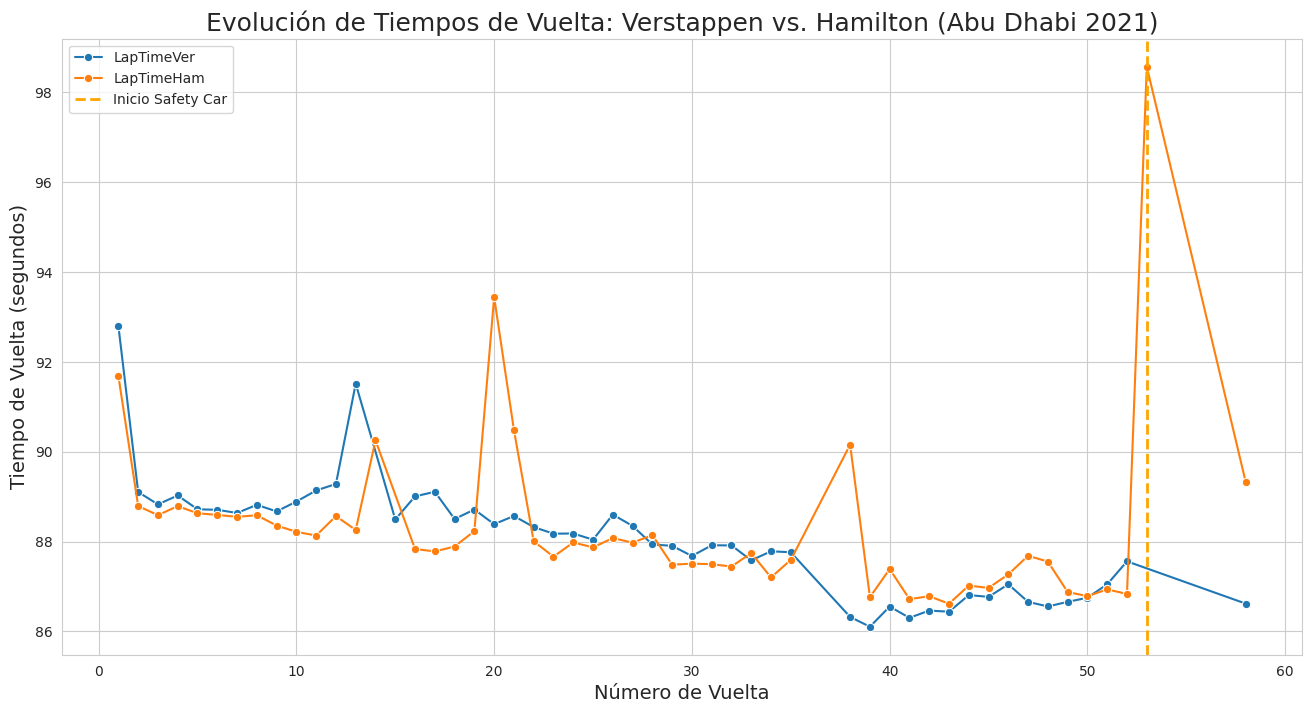

In [35]:
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

# Graficamos los datos "tidy"
sns.lineplot(
    data=tidy_df,
    x='LapNumber',
    y='Tiempo de Vuelta',
    hue='Piloto', # Esto crea una línea diferente para cada piloto
    marker='o'
)

# Marcar el evento clave de la carrera para dar contexto
plt.axvline(x=53, color='orange', linestyle='--', linewidth=2, label='Inicio Safety Car')

plt.title('Evolución de Tiempos de Vuelta: Verstappen vs. Hamilton (Abu Dhabi 2021)', fontsize=18)
plt.xlabel('Número de Vuelta', fontsize=14)
plt.ylabel('Tiempo de Vuelta (segundos)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [36]:
#Funcion para crear secuencias
def create_sequences(data, sequence_length):
  X, y = [], []
  for i in range(len(data)-sequence_length):
    X.append(data[i:i+sequence_length])
    y.append(data[i+sequence_length])
  return np.array(X), np.array(y)

#Para predecir la siguiente vuelta uso las 5 anteriores
sequence_len = 5

In [37]:
# PREPARACIÓN DE DATOS CON TRAIN/TEST SPLIT
#Preprocesamiento de datos de los pilotos

# --- Verstappen ---
data_ver = lap_times_ver['LapTime'].values.reshape(-1, 1)

# Dividimos los datos: 80% para entrenar, 20% para probar
train_size_ver = int(len(data_ver) * 0.8)
train_data_ver = data_ver[:train_size_ver]
test_data_ver = data_ver[train_size_ver - sequence_len:] # Overlap para la primera secuencia de test

# Escalamos los datos
scaler_ver = MinMaxScaler(feature_range=(0, 1))
train_scaled_ver = scaler_ver.fit_transform(train_data_ver)
test_scaled_ver = scaler_ver.transform(test_data_ver)

# Creamos las secuencias de entrenamiento y prueba
X_train_ver, y_train_ver = create_sequences(train_scaled_ver, sequence_len)
X_test_ver, y_test_ver = create_sequences(test_scaled_ver, sequence_len)

# Reshape para los modelos
X_train_ver = np.reshape(X_train_ver, (X_train_ver.shape[0], X_train_ver.shape[1], 1))
X_test_ver = np.reshape(X_test_ver, (X_test_ver.shape[0], X_test_ver.shape[1], 1))

# --- Hamilton ---
data_ham = lap_times_ham['LapTime'].values.reshape(-1, 1)
train_size_ham = int(len(data_ham) * 0.8)
train_data_ham = data_ham[:train_size_ham]
test_data_ham = data_ham[train_size_ham - sequence_len:]

scaler_ham = MinMaxScaler(feature_range=(0, 1))
train_scaled_ham = scaler_ham.fit_transform(train_data_ham)
test_scaled_ham = scaler_ham.transform(test_data_ham)

X_train_ham, y_train_ham = create_sequences(train_scaled_ham, sequence_len)
X_test_ham, y_test_ham = create_sequences(test_scaled_ham, sequence_len)

X_train_ham = np.reshape(X_train_ham, (X_train_ham.shape[0], X_train_ham.shape[1], 1))
X_test_ham = np.reshape(X_test_ham, (X_test_ham.shape[0], X_test_ham.shape[1], 1))

print("Datos de Train/Test creados correctamente.")

Datos de Train/Test creados correctamente.


In [38]:
def build_functional_rnn_model(sequence_length):
    """
    Construye un modelo SimpleRNN usando la API Funcional de Keras.
    """
    input_layer = Input(shape=(sequence_length, 1))
    # Primera capa RNN
    x = SimpleRNN(units=32, return_sequences=True)(input_layer)
    x = LayerNormalization()(x)
    x = Dropout(rate=0.2)(x)

    # Segunda capa RNN
    x = SimpleRNN(units=16)(x) # return_sequences=False para la última capa
    x = LayerNormalization()(x)
    x = Dropout(rate=0.2)(x)

    # Output
    x = Dense(8)(x)
    output_layer = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [39]:
# Construir Modelo RNN de cada piloto
model_ver_rnn = build_functional_rnn_model(sequence_len)
model_ham_rnn = build_functional_rnn_model(sequence_len)

# Imprimir el resumen de la arquitectura
print("Arquitectura del Modelo RNN (API Funcional):")
model_ver_rnn.summary()

# Entrenamiento
print("\nEntrenando modelo RNN para Verstappen...")
model_ver_rnn.fit(X_train_ver, y_train_ver, batch_size=1, epochs=20, verbose=0)
print("Modelo de Verstappen entrenado.")

print("\nEntrenando modelo RNN para Hamilton...")
model_ham_rnn.fit(X_train_ham, y_train_ham, batch_size=1, epochs=20, verbose=0)
print("Modelo de Hamilton entrenado.")

Arquitectura del Modelo RNN (API Funcional):


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 5, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, 5, 32)          │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_20          │ (None, 5, 32)          │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_21          │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,113 (8.25 KB)

 Trainable params: 2,113 (8.25 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando modelo RNN para Verstappen...
Modelo de Verstappen entrenado.

Entrenando modelo RNN para Hamilton...
Modelo de Hamilton entrenado.


In [40]:
# Predicciones con los modelos RNN
predictions_ver_rnn = model_ver_rnn.predict(X_test_ver)
predictions_ham_rnn = model_ham_rnn.predict(X_test_ham)

# Normalizacion de los resultados para que estén en segundos
predictions_ver_rnn_inv = scaler_ver.inverse_transform(predictions_ver_rnn)
predictions_ham_rnn_inv = scaler_ham.inverse_transform(predictions_ham_rnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


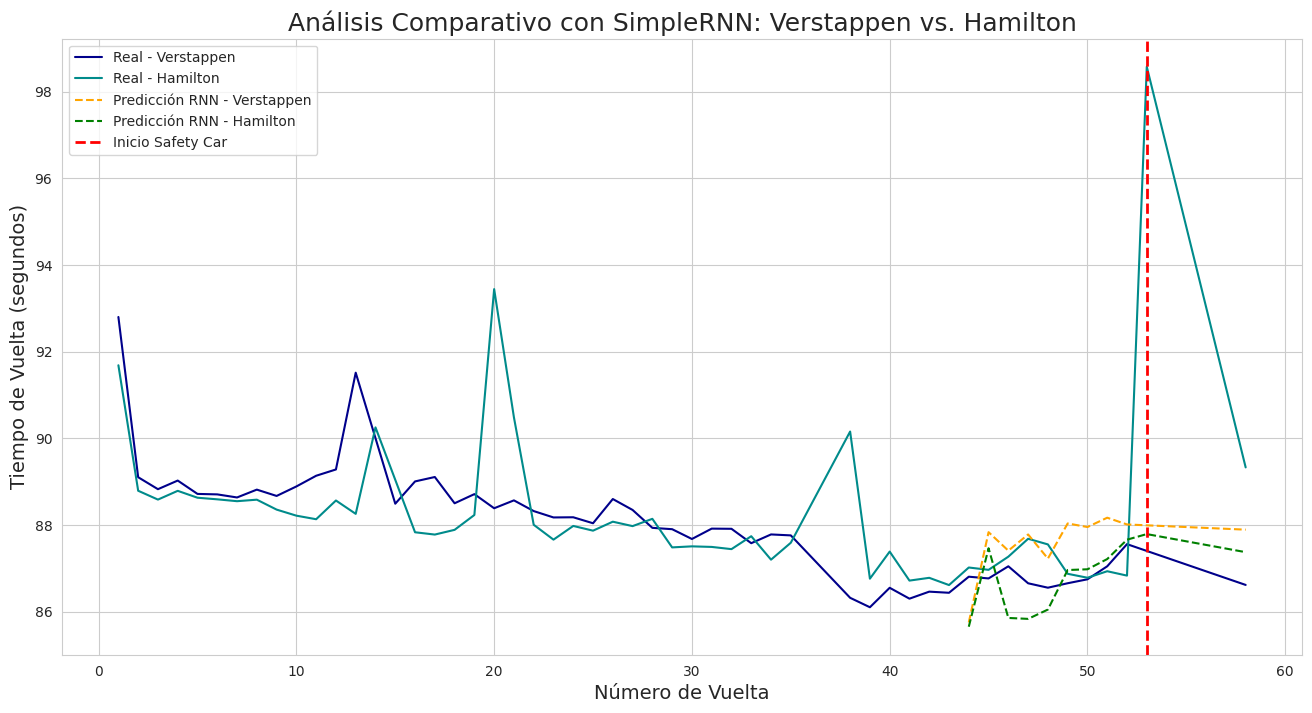

In [42]:
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

# Datos Reales
plt.plot(lap_times_ver.index, lap_times_ver['LapTime'], label='Real - Verstappen', color='darkblue')
plt.plot(lap_times_ham.index, lap_times_ham['LapTime'], label='Real - Hamilton', color='darkcyan')

# Predicciones RNN
# Se debe alinear el índice para que las predicciones comiencen después de la primera secuencia
# Adjust the index slicing to match the number of predictions
index_ver_pred = lap_times_ver.index[train_size_ver:]
index_ham_pred = lap_times_ham.index[train_size_ham:]

plt.plot(index_ver_pred, predictions_ver_rnn_inv, label='Predicción RNN - Verstappen', color='orange', linestyle='--')
plt.plot(index_ham_pred, predictions_ham_rnn_inv, label='Predicción RNN - Hamilton', color='green', linestyle='--')

# Marcar el evento clave de la carrera para dar contexto
plt.axvline(x=53, color='red', linestyle='--', linewidth=2, label='Inicio Safety Car')

plt.title('Análisis Comparativo con SimpleRNN: Verstappen vs. Hamilton', fontsize=18)
plt.xlabel('Número de Vuelta', fontsize=14)
plt.ylabel('Tiempo de Vuelta (segundos)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Des-normalizar los valores 'Y' reales
# Necesitamos comparar las predicciones (en segundos) con los valores reales (también en segundos).
real_ver_inv = scaler_ver.inverse_transform(y_test_ver.reshape(-1, 1))
real_ham_inv = scaler_ham.inverse_transform(y_test_ham.reshape(-1, 1))

# Calcular Métricas para Verstappen (RNN)
rmse_ver_rnn = np.sqrt(mean_squared_error(real_ver_inv, predictions_ver_rnn_inv))
mae_ver_rnn = mean_absolute_error(real_ver_inv, predictions_ver_rnn_inv)

print("Métricas del Modelo SimpleRNN (Verstappen)")
print(f"RMSE: {rmse_ver_rnn:.4f} segundos")
print(f"MAE:  {mae_ver_rnn:.4f} segundos")
print(f"(El modelo se equivoca, en promedio, por ~{mae_ver_rnn:.2f} segundos en cada predicción de vuelta)")


# Calcular Métricas para Hamilton (RNN)
rmse_ham_rnn = np.sqrt(mean_squared_error(real_ham_inv, predictions_ham_rnn_inv))
mae_ham_rnn = mean_absolute_error(real_ham_inv, predictions_ham_rnn_inv)

print("\nMétricas del Modelo SimpleRNN (Hamilton)")
print(f"RMSE: {rmse_ham_rnn:.4f} segundos")
print(f"MAE:  {mae_ham_rnn:.4f} segundos")
print(f"(El modelo se equivoca, en promedio, por ~{mae_ham_rnn:.2f} segundos en cada predicción de vuelta)")

Métricas del Modelo SimpleRNN (Verstappen)
RMSE: 1.0271 segundos
MAE:  0.9717 segundos
(El modelo se equivoca, en promedio, por ~0.97 segundos en cada predicción de vuelta)

Métricas del Modelo SimpleRNN (Hamilton)
RMSE: 3.4470 segundos
MAE:  1.8874 segundos
(El modelo se equivoca, en promedio, por ~1.89 segundos en cada predicción de vuelta)


## Análisis del Modelo SimpleRNN
El modelo SimpleRNN demostró ser sorprendentemente efectivo para esta tarea.

Hallazgo: Como se observa en el gráfico, la línea de predicción (punteada) _sigue de cerca la tendencia de los datos reales_. El modelo fue capaz de aprender el patrón de degradación de los neumáticos y el ritmo general de los pilotos.

### Métricas (Verstappen):

 * __RMSE:__ 1.0271 segundos

 * __MAE:__ 0.9717 segundos

### Métricas (Hamilton):

* __RMSE:__ 3.4470 segundos

* __MAE:__ 1.8874 segundos

El bajo error promedio (MAE) indica que la _SimpleRNN_, a pesar de su simplicidad, establece una línea de base muy sólida para este problema.

### Modelado con LSTM

In [44]:
def build_functional_lstm_model(sequence_length):
    """
    Construye un modelo LSTM apilado usando la API Funcional de Keras.
    """
    # Capa de entrada
    input_layer = Input(shape=(sequence_length, 1))

    # Primera capa LSTM
    # return_sequences=True para pasar la secuencia a la siguiente capa
    x = LSTM(units=32, return_sequences=True)(input_layer)
    x = LayerNormalization()(x)
    x = Dropout(rate=0.2)(x)

    # Segunda capa LSTM
    x = LSTM(units=16)(x)
    x = LayerNormalization()(x)
    x = Dropout(rate=0.2)(x)

    # Output
    x = Dense(8, activation='relu')(x)
    output_layer = Dense(1)(x)

    # Crear y compilar el modelo
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [46]:
# Construir un modelo LSTM para cada piloto
model_ver_lstm = build_functional_lstm_model(sequence_len)
model_ham_lstm = build_functional_lstm_model(sequence_len)

# Imprimir el resumen de la arquitectura
print("Arquitectura del Modelo LSTM (API Funcional):")
model_ver_lstm.summary()

# Entrenar los modelos LSTM
print("\nEntrenando modelo LSTM para Verstappen...")
model_ver_lstm.fit(X_train_ver, y_train_ver, batch_size=1, epochs=20, verbose=0)
print("Modelo de Verstappen entrenado.")

print("\nEntrenando modelo LSTM para Hamilton...")
model_ham_lstm.fit(X_train_ham, y_train_ham, batch_size=1, epochs=20, verbose=0)
print("Modelo de Hamilton entrenado.")

Arquitectura del Modelo LSTM (API Funcional):


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 5, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 5, 32)          │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_28          │ (None, 5, 32)          │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_29          │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,729 (30.19 KB)

 Trainable params: 7,729 (30.19 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando modelo LSTM para Verstappen...
Modelo de Verstappen entrenado.

Entrenando modelo LSTM para Hamilton...
Modelo de Hamilton entrenado.


In [47]:
# Realizar las predicciones con los modelos LSTM
predictions_ver_lstm = model_ver_lstm.predict(X_test_ver)
predictions_ham_lstm = model_ham_lstm.predict(X_test_ham)

# Invertir la normalización
predictions_ver_lstm_inv = scaler_ver.inverse_transform(predictions_ver_lstm)
predictions_ham_lstm_inv = scaler_ham.inverse_transform(predictions_ham_lstm)

print("\n¡Modelos LSTM listos!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step

¡Modelos LSTM listos!


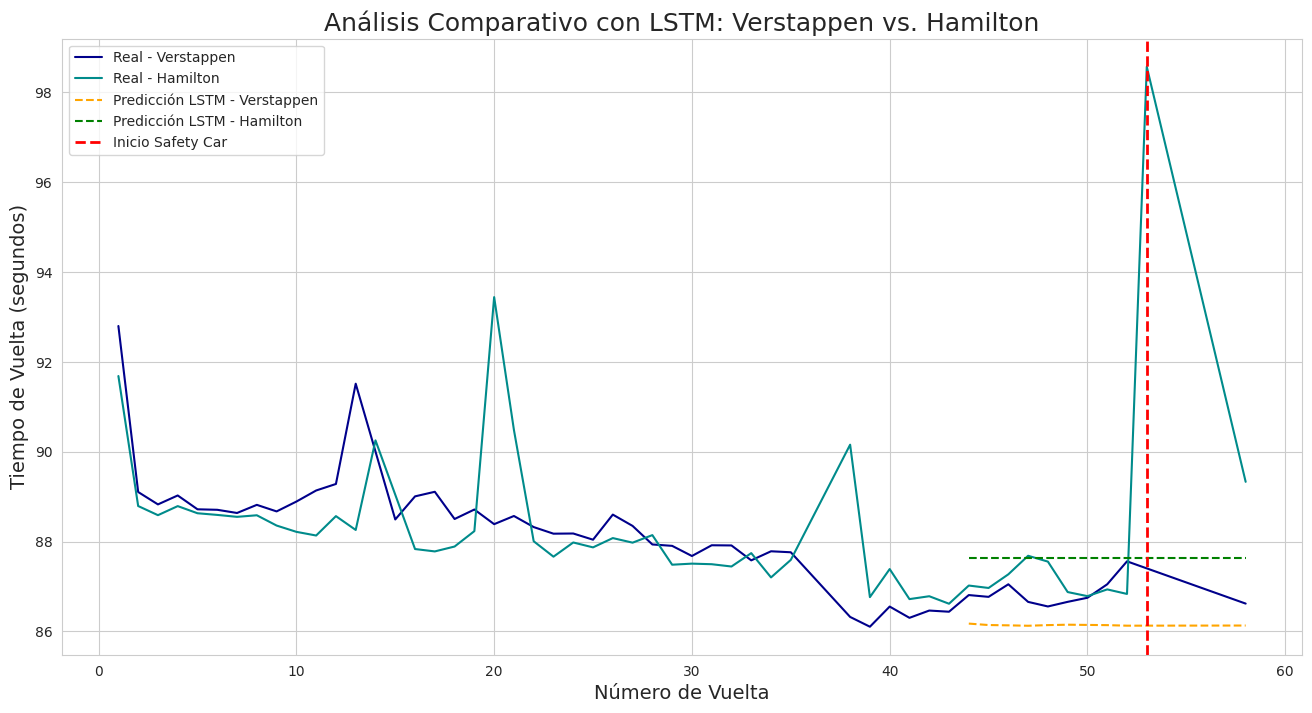

In [49]:
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

# Datos Reales
# Graficamos los datos de tiempo de vuelta originales y limpios
plt.plot(lap_times_ver.index, lap_times_ver['LapTime'], label='Real - Verstappen', color='darkblue')
plt.plot(lap_times_ham.index, lap_times_ham['LapTime'], label='Real - Hamilton', color='darkcyan')

# Predicciones LSTM (Ajuste del Modelo)
# Adjust the index slicing to match the number of predictions
index_ver_pred = lap_times_ver.index[train_size_ver:]
index_ham_pred = lap_times_ham.index[train_size_ham:]

# Graficamos las predicciones (des-normalizadas)
plt.plot(index_ver_pred, predictions_ver_lstm_inv, label='Predicción LSTM - Verstappen', color='orange', linestyle='--')
plt.plot(index_ham_pred, predictions_ham_lstm_inv, label='Predicción LSTM - Hamilton', color='green', linestyle='--')

# Marcar el evento clave de la carrera
plt.axvline(x=53, color='red', linestyle='--', linewidth=2, label='Inicio Safety Car')

plt.title('Análisis Comparativo con LSTM: Verstappen vs. Hamilton', fontsize=18)
plt.xlabel('Número de Vuelta', fontsize=14)
plt.ylabel('Tiempo de Vuelta (segundos)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# Des-normalizar los valores Y reales
real_ver_inv = scaler_ver.inverse_transform(y_test_ver.reshape(-1, 1))
real_ham_inv = scaler_ham.inverse_transform(y_test_ham.reshape(-1, 1))

# Calcular Métricas para Verstappen (LSTM)
rmse_ver_lstm = np.sqrt(mean_squared_error(real_ver_inv, predictions_ver_lstm_inv))
mae_ver_lstm = mean_absolute_error(real_ver_inv, predictions_ver_lstm_inv)

print("Métricas del Modelo LSTM (Verstappen)")
print(f"RMSE: {rmse_ver_lstm:.4f} segundos")
print(f"MAE:  {mae_ver_lstm:.4f} segundos")
print(f"(El modelo se equivoca, en promedio, por ~{mae_ver_lstm:.2f} segundos en cada predicción de vuelta)")

# Calcular Métricas para Hamilton (LSTM)
rmse_ham_lstm = np.sqrt(mean_squared_error(real_ham_inv, predictions_ham_lstm_inv))
mae_ham_lstm = mean_absolute_error(real_ham_inv, predictions_ham_lstm_inv)

print("\nMétricas del Modelo LSTM (Hamilton)")
print(f"RMSE: {rmse_ham_lstm:.4f} segundos")
print(f"MAE:  {mae_ham_lstm:.4f} segundos")
print(f"(El modelo se equivoca, en promedio, por ~{mae_ham_lstm:.2f} segundos en cada predicción de vuelta)")

Métricas del Modelo LSTM (Verstappen)
RMSE: 0.7637 segundos
MAE:  0.7069 segundos
(El modelo se equivoca, en promedio, por ~0.71 segundos en cada predicción de vuelta)

Métricas del Modelo LSTM (Hamilton)
RMSE: 3.3851 segundos
MAE:  1.5903 segundos
(El modelo se equivoca, en promedio, por ~1.59 segundos en cada predicción de vuelta)


## Análisis del Modelo LSTM (Long Short-Term Memory)
Se utilizó la misma arquitectura 32 -> 16 -> 8, reemplazando las capas SimpleRNN por capas LSTM. Los resultados fueron inesperados.

__Hallazgo:__ El modelo LSTM _falló_ en aprender el patrón. El gráfico de predicción muestra una línea recta, un síntoma claro de subajuste (underfitting). Aunque el MAE y el RSME  sean inferiores al SimpleRNN esto es un problema ya que el modelo no entiende los datos.

_¿Por qué ocurrió esto?_

Una capa LSTM es _intrínsecamente_ mucho más compleja que una SimpleRNN (tiene __~4__ veces más parámetros internos). Al darle un modelo tan complejo a un conjunto de datos tan pequeño (aprox. 50-60 vueltas por piloto), el Modelo no logró converger en una solución útil y optó por la predicción más segura: __el valor promedio de la serie.__

## Conclusión y Próximos Pasos

Este análisis nos deja un hallazgo clave: el modelo SimpleRNN (más simple) superó al LSTM (más complejo), no porque las LSTMs sean peores, sino porque nuestra arquitectura de LSTM era __demasiado compleja__ para el tamaño de este dataset.

Esto demuestra un claro trade-off entre la complejidad del modelo y el riesgo de sobreajuste/subajuste.

Los siguientes pasos lógicos serian encontrar el equilibrio perfecto:

Simplificar la LSTM: Primero, probar una arquitectura LSTM mucho más simple (por ejemplo, con una sola capa) para reducir su complejidad. El objetivo es ver si una LSTM más ligera puede evitar el problema de convergencia y aprender el patrón correctamente.

Optimizar la RNN: Si la LSTM simplificada no muestra una mejora significativa, procederemos a optimizar el modelo SimpleRNN (que ya sabemos que funciona) utilizando un _"Tuner"_ como __Keras Tuner__ para encontrar la mejor combinación de hiperparámetros y maximizar su rendimiento.